## CU Boulder 4604/5604

#### September 28, 2020

####  Logistic regression revisited

### Logistic Regression revisited

- Last week we learned about logistic regression and regularization
- Today, we are going modify the notebook from last week in 2 ways 

##### New stuff:
1. We are going to add a regularization term to the loss function
2. We will introduce stochastic gradient descent. The well-known ML researcher [Dave Blei](http://www.cs.columbia.edu/~blei/) says stoachstic gradient descent is like walking from New York to Los Angeles by asking one person at a time for directions. And every person you ask for directions is drunk. Even though this seems like a bad way to get across the country, we will see that is has clear advantages
3. We will split training data and test data, and look at the effects of regularization
4. I filled in the missing functions from last week if you are curious. Everyone who submitted last week got full credit. These notebooks are a way to get your hands dirty with real ML code so you learn the materials more deeply. They are not a way for me to quiz you on what you know. That is what HW, quizzes, exams are for ...
5. I changed the code from gradient ascent to gradient descent (flipping signs as needed). Recall that maximizing log likelihood is the same as minimizing negative log likelihood.

### Annoucements 

- Recall HW2 is out
- This notebook is pretty similar to HW2
- In the real world, it is OK to lean on sklearn's implementation of logistic regression
- But taking this class gives you a chance to actually understand how it works. This notebook should make the sklearn code much less mysterious

In [6]:
%matplotlib inline

import math
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

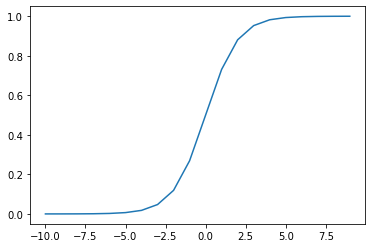

In [4]:
## Here is the logistic function, the activation function for logistic regression

def logistic(z):
    return 1/(1 + np.exp(-z))

x, fz = [], []
for z in range(-10, 10):
    x.append(z)
    fz.append(logistic(z))

plt.plot(x, fz)

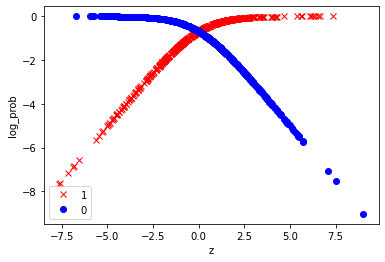

In [5]:
## Let's generate some features, weights and y values and compute the loss 
## This can help you build up intuition for what is happening

def log_prob(z, y_i):
    '''
    Returns the log_prob for one point
    '''
    fz = logistic(z)
    return y_i * np.log(fz) + (1 - y_i) * np.log(1 - fz)


out = []

dim_ = 10

for _ in range(1000):
    # generate some random weights 
    w = np.random.uniform(low=-2, high=2, size=dim_)
    
    # generate some random binary features 
    x = (np.random.rand(dim_) > .5).astype(int) 
    
    # get the z score
    z = w.dot(x)

    # randomly assign y
    y = 1 if random.random() < .5 else 0
    
    # compute the loss
    loss = log_prob(z=z, y_i=y)
    
    # keep track of what is happening
    out.append({"z": z, "loss": loss, "label": y})


# Plot the results
df = pd.DataFrame(out)
    
fig, ax = plt.subplots()
ax.plot(df[df["label"] == 1]["z"], df[df["label"] == 1]["loss"], 'x', color="red", label='1')
ax.plot(df[df["label"] == 0]["z"], df[df["label"] == 0]["loss"], 'o', color="blue", label='0')
plt.xlabel("z")
plt.ylabel("log_prob")
plt.legend()
plt.show()

In [28]:
def neg_log_likelihood(X, w, y):
    '''Compute the negative log likelihood'''
    L = 0
    for _x,_y in zip(X, y):
        z = w.dot(_x)
        L += log_prob(z=z, y_i=_y)
    return -1 * L


def fast_logistic(X, w):
    '''Compute the logistic function over many data points'''
    return 1/(1 + np.exp(-1 * X.dot(w)))


def grad(X, w, y):
    '''Return the gradient'''
    grad = np.zeros_like(w)
    for _x,_y in zip(X, y):
        fz = logistic(w.dot(_x))
        grad += _x * (_y - fz)
    return -1 * grad    


def grad_decent(X, y, eta = .0001, tolerance=1e-4, verbose=True):
    '''
    - Perform gradient ascent
    - This function is basically the same as in the Adeline notebook
    - Of course, the gradient is different, because it is a different function
    '''
    w = np.random.uniform(low=-5, high=2, size=dim_)
    last = 0
    for i in range(1000):
        this_ll = neg_log_likelihood(X, w, y)
        if verbose:
            print("iter: {}, neg ll: {}, accuracy: {}".format(i, this_ll, accuracy(X, w, y)))
        if(abs(this_ll - last) < tolerance): break
        last = this_ll
        w -= eta * grad(X, w, y)
    return w

def prediction(X, w, threshold=.5):
    '''
    - Return a Boolean array of length N.
    - The array should be True if the weights dotted with the features for a given instance is greater than .5
    '''
    N, D = X.shape
    return X.dot(w) > threshold

def accuracy(X, w, y):
    '''
    Return a value between 0 and 1, showing the fraction of data points which have been classified correctly
    '''
    return np.mean(prediction(X, w) == y)

def init_data(N, dim_):
    '''
    Initialize data. Note how we generate y below. We know how the data is generated.
    We should be able to 
    '''
    w = np.random.uniform(low=-2, high=2, size=dim_)
    X = (np.random.rand(dim_ * N) > .5).astype(int)
    X = X.reshape(N, dim_)

    z_ = X[:,0] * 2 +  X[:,1] * -2 +  X[:,2] * 3 + X[:,3] * 4

    y =  1/(1 + np.exp(-1 * z_)) > .5
    
    return X, y

N = 10000
dim_ = 4
w = np.random.uniform(low=-5, high=2, size=dim_)
X, y = init_data(N, dim_)
w = grad_decent(X, y, eta=.0001, tolerance=5, verbose=True)

#neg_log_likelihood(X, w, y)

iter: 0, neg ll: 42370.04794299019, accuracy: 0.2479
iter: 1, neg ll: 35370.40901700881, accuracy: 0.3126
iter: 2, neg ll: 28850.814821885437, accuracy: 0.3126
iter: 3, neg ll: 23044.62877845306, accuracy: 0.3126
iter: 4, neg ll: 18216.28261301992, accuracy: 0.4361
iter: 5, neg ll: 14442.007305396346, accuracy: 0.5026
iter: 6, neg ll: 11626.35713803692, accuracy: 0.5664
iter: 7, neg ll: 9609.994919277047, accuracy: 0.5036
iter: 8, neg ll: 8174.02669611055, accuracy: 0.6326
iter: 9, neg ll: 7116.047299438249, accuracy: 0.6326
iter: 10, neg ll: 6304.86721587038, accuracy: 0.6326
iter: 11, neg ll: 5665.075534521254, accuracy: 0.6326
iter: 12, neg ll: 5151.695771799171, accuracy: 0.6956
iter: 13, neg ll: 4735.133432216919, accuracy: 0.6956
iter: 14, neg ll: 4394.018970778181, accuracy: 0.6956
iter: 15, neg ll: 4112.044190300059, accuracy: 0.6956
iter: 16, neg ll: 3876.507843150038, accuracy: 0.6956
iter: 17, neg ll: 3677.5045437911513, accuracy: 0.6956
iter: 18, neg ll: 3507.3476185046557,

KeyboardInterrupt: 